In [1]:
import pandas as pd
import matplotlib
%matplotlib inline

In [2]:
#pops = pd.read_csv("data/pop-est-by-race.csv") # ACS data (2018 is 2017 data)
pops = pd.read_csv("data/popest-race.csv") # POPEST data (2017 is 2017)
pops.columns = ["race"] + pops.columns.tolist()[1:]
pops = pops.set_index("race")
pops.columns = [int(x) for x in pops.columns.tolist()]
pops.transpose()

race,white,black,hispanic,total,other
2012,2542435,333894,480185,3572213,215699
2013,2526401,337758,496939,3583561,222463
2014,2508360,342043,512795,3592053,228855
2015,2487119,346206,526508,3593222,233389
2016,2464450,347674,537728,3588570,238718
2017,2446049,350820,551916,3594478,245693
2018,2446049,350820,551916,3594478,245693


In [3]:
drugdeaths = pd.read_csv("data/drug-deaths-with-race-and-year-columns.csv")
drugdeaths.head(1)

,Unnamed: 0,ID,Date,DateType,Age,Sex,Race,ResidenceCity,ResidenceCounty,ResidenceState,...,Other,OpiateNOS,AnyOpioid,MannerofDeath,DeathCityGeo,InjuryCityGeo,ResidenceCityGeo,year,year_2,race_4
0,0,12-0001,01/01/2012 12:00:00 AM,DateofDeath,35.0,Male,White,HEBRON,TOLLAND,NaN,...,NaN,NaN,NaN,Accident,"HEBRON, CT\n(41.658069, -72.366324)",NaN,"HEBRON\n(43.694742, -71.808963)",2012.0,2012,white


# Beware of slight differences in annual totals


In [4]:
drugdeaths["year_2"].value_counts().sort_index()#.to_frame().sort_index()
# Should be 357 495 568 729 917 1038 1017
#            +2  +5 +10   0   0   +1   +1e

2012     355
2013     490
2014     558
2015     729
2016     917
2017    1038
2018    1018
Name: year_2, dtype: int64

In [5]:
fendeaths = drugdeaths[(drugdeaths["Fentanyl"].apply(lambda x: "Y" in str(x).upper()))
                      | (drugdeaths["FentanylAnalogue"].apply(lambda x: "Y" in str(x).upper()))]

In [6]:
fendeaths["year_2"] = fendeaths["year_2"].astype(str)

/Users/jakekara/Code/pandas3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [7]:
fendeaths["year_2"].value_counts().to_frame().sort_index()
# should be 14 37 75 189 483 677 760
#            0  0  0  +1  +1   0   0

,year_2
2012,14
2013,37
2014,75
2015,188
2016,482
2017,677
2018,760


In [8]:
import numpy as np

def year_race(df):
    tmpdf = df.copy()
    ret = pd.pivot_table(tmpdf.groupby(["race_4","year_2"]).agg({"ID":np.size}).reset_index(),
                   values="ID",
                   columns="race_4",
                   index="year_2")
    ret = ret.join(df["year_2"].value_counts().to_frame().sort_index())
    ret.columns = ret.columns.tolist()[:-1] + ["total"]
    
    return ret
fendeaths_race = year_race(fendeaths)
fendeaths_race

,black,hispanic,other,white,total
year_2,,,,,
2012,NaN,1.0,NaN,13.0,14
2013,4.0,6.0,1.0,26.0,37
2014,4.0,9.0,1.0,61.0,75
2015,8.0,22.0,4.0,154.0,188
2016,32.0,62.0,8.0,380.0,482
2017,55.0,80.0,9.0,533.0,677
2018,79.0,102.0,16.0,563.0,760


In [9]:
year_race(drugdeaths)

,black,hispanic,other,white,total
year_2,,,,,
2012,38,38,5,274,355
2013,44,52,6,388,490
2014,27,57,6,468,558
2015,46,79,10,594,729
2016,86,101,19,711,917
2017,88,122,15,813,1038
2018,104,136,22,756,1018


In [10]:
def add_pct(df):

    ret = df.copy()
    
    for c in ["black","white","hispanic"]:#,"other"]:
        ret["%s_pct" %c] = ret[c] / ret["total"]
    
    return ret
add_pct(fendeaths_race)

,black,hispanic,other,white,total,black_pct,white_pct,hispanic_pct
year_2,,,,,,,,
2012,NaN,1.0,NaN,13.0,14,NaN,0.928571,0.071429
2013,4.0,6.0,1.0,26.0,37,0.108108,0.702703,0.162162
2014,4.0,9.0,1.0,61.0,75,0.053333,0.813333,0.120000
2015,8.0,22.0,4.0,154.0,188,0.042553,0.819149,0.117021
2016,32.0,62.0,8.0,380.0,482,0.066390,0.788382,0.128631
2017,55.0,80.0,9.0,533.0,677,0.081241,0.787297,0.118168
2018,79.0,102.0,16.0,563.0,760,0.103947,0.740789,0.134211


In [11]:
def add_pop(df):
    
    ret = df.copy()
    ret = ret.transpose()
    ret.columns = [int(x) for x in ret.columns.tolist()]
    ret = ret.transpose()
    return ret.join(pops.transpose(), rsuffix="_pop")


fendeaths_race = add_pop(fendeaths_race)

fendeaths_race

,black,hispanic,other,white,total,white_pop,black_pop,hispanic_pop,total_pop,other_pop
2012,NaN,1.0,NaN,13.0,14.0,2542435,333894,480185,3572213,215699
2013,4.0,6.0,1.0,26.0,37.0,2526401,337758,496939,3583561,222463
2014,4.0,9.0,1.0,61.0,75.0,2508360,342043,512795,3592053,228855
2015,8.0,22.0,4.0,154.0,188.0,2487119,346206,526508,3593222,233389
2016,32.0,62.0,8.0,380.0,482.0,2464450,347674,537728,3588570,238718
2017,55.0,80.0,9.0,533.0,677.0,2446049,350820,551916,3594478,245693
2018,79.0,102.0,16.0,563.0,760.0,2446049,350820,551916,3594478,245693


In [12]:
def add_percap(df):
    ret = df.copy()
    for c in ["black","white","hispanic"]:#,"other"]:
        ret["%s_per100k" %c] = ret[c] * 100000 / ret["%s_pop" %c]
        
    return ret
fendeaths_race = add_percap(fendeaths_race)
fendeaths_race



,black,hispanic,other,white,total,white_pop,black_pop,hispanic_pop,total_pop,other_pop,black_per100k,white_per100k,hispanic_per100k
2012,NaN,1.0,NaN,13.0,14.0,2542435,333894,480185,3572213,215699,NaN,0.511321,0.208253
2013,4.0,6.0,1.0,26.0,37.0,2526401,337758,496939,3583561,222463,1.184280,1.029132,1.207392
2014,4.0,9.0,1.0,61.0,75.0,2508360,342043,512795,3592053,228855,1.169444,2.431868,1.755087
2015,8.0,22.0,4.0,154.0,188.0,2487119,346206,526508,3593222,233389,2.310763,6.191903,4.178474
2016,32.0,62.0,8.0,380.0,482.0,2464450,347674,537728,3588570,238718,9.204024,15.419262,11.529993
2017,55.0,80.0,9.0,533.0,677.0,2446049,350820,551916,3594478,245693,15.677555,21.790242,14.494959
2018,79.0,102.0,16.0,563.0,760.0,2446049,350820,551916,3594478,245693,22.518671,23.016710,18.481073


In [13]:
def summarize(df):
    ret = year_race(df.copy())
    ret = add_pop(ret)
    #ret = add_pct(ret)
    ret = add_percap(ret)
    return ret
    
summarize(fendeaths)

,black,hispanic,other,white,total,white_pop,black_pop,hispanic_pop,total_pop,other_pop,black_per100k,white_per100k,hispanic_per100k
2012,NaN,1.0,NaN,13.0,14.0,2542435,333894,480185,3572213,215699,NaN,0.511321,0.208253
2013,4.0,6.0,1.0,26.0,37.0,2526401,337758,496939,3583561,222463,1.184280,1.029132,1.207392
2014,4.0,9.0,1.0,61.0,75.0,2508360,342043,512795,3592053,228855,1.169444,2.431868,1.755087
2015,8.0,22.0,4.0,154.0,188.0,2487119,346206,526508,3593222,233389,2.310763,6.191903,4.178474
2016,32.0,62.0,8.0,380.0,482.0,2464450,347674,537728,3588570,238718,9.204024,15.419262,11.529993
2017,55.0,80.0,9.0,533.0,677.0,2446049,350820,551916,3594478,245693,15.677555,21.790242,14.494959
2018,79.0,102.0,16.0,563.0,760.0,2446049,350820,551916,3594478,245693,22.518671,23.016710,18.481073


In [14]:
summarize(drugdeaths).index

Int64Index([2012, 2013, 2014, 2015, 2016, 2017, 2018], dtype='int64')

In [15]:
pops.transpose().index

Int64Index([2012, 2013, 2014, 2015, 2016, 2017, 2018], dtype='int64')

In [16]:
summarize(drugdeaths)

,black,hispanic,other,white,total,white_pop,black_pop,hispanic_pop,total_pop,other_pop,black_per100k,white_per100k,hispanic_per100k
2012,38,38,5,274,355,2542435,333894,480185,3572213,215699,11.380857,10.777070,7.913617
2013,44,52,6,388,490,2526401,337758,496939,3583561,222463,13.027079,15.357815,10.464061
2014,27,57,6,468,558,2508360,342043,512795,3592053,228855,7.893744,18.657609,11.115553
2015,46,79,10,594,729,2487119,346206,526508,3593222,233389,13.286887,23.883055,15.004520
2016,86,101,19,711,917,2464450,347674,537728,3588570,238718,24.735816,28.850251,18.782730
2017,88,122,15,813,1038,2446049,350820,551916,3594478,245693,25.084089,33.237274,22.104813
2018,104,136,22,756,1018,2446049,350820,551916,3594478,245693,29.644832,30.906985,24.641431


In [26]:
print (summarize(fendeaths)[["%s_per100k" % x for x in ["white","black","hispanic"]]].to_csv(
    sep="\t",
    float_format="%.1f"
))

	white_per100k	black_per100k	hispanic_per100k
2012	0.5		0.2
2013	1.0	1.2	1.2
2014	2.4	1.2	1.8
2015	6.2	2.3	4.2
2016	15.4	9.2	11.5
2017	21.8	15.7	14.5
2018	23.0	22.5	18.5



In [18]:
#summarize(drugdeaths)[["%s_per100k" % x for x in ["white","black","hispanic"]]]

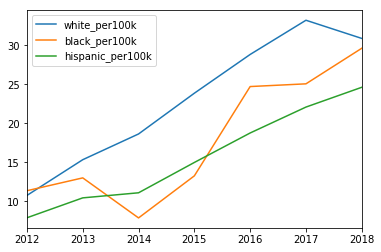

In [19]:
summarize(drugdeaths)[["%s_per100k" % x for x in ["white","black","hispanic"]]].plot()

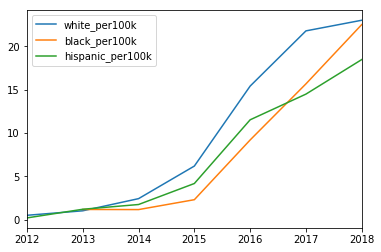

In [20]:
summarize(fendeaths)[["%s_per100k" % x for x in ["white","black","hispanic"]]].plot()

In [21]:
# totals
pop_trans = pops.transpose()
pop_trans = pop_trans.set_index(pop_trans.index.map(lambda x: str(x)))
pop_trans
fen_totals = fendeaths.groupby("year_2").agg({"ID":np.size}).join(pop_trans[["total"]])
fen_totals["per100k"] = fen_totals["ID"] * 100000 / fen_totals["total"]
fen_totals

,ID,total,per100k
year_2,,,
2012,14,3572213,0.391914
2013,37,3583561,1.032493
2014,75,3592053,2.087942
2015,188,3593222,5.232073
2016,482,3588570,13.431534
2017,677,3594478,18.834446
2018,760,3594478,21.143543


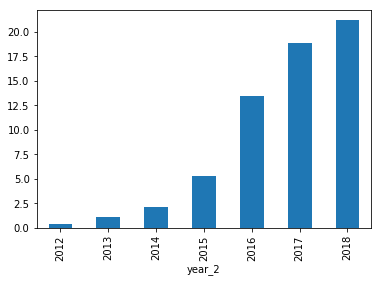

In [22]:
fen_totals["per100k"].plot.bar()

# Conclusions

Note: There are some discrepancies in overal overdose deaths of up to 10 in one year between these underlying data and the OCME annual statistical summary. Fentanyl death totals were not off by more than 1 per year, so the impact on rates per 100K is negligible. 
